In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
import pmdarima as pm
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="google.protobuf")
import warnings
warnings.filterwarnings("ignore", category=FutureWarning, module="sklearn")

In [18]:
# -----------------------------------------------------------------------------
# Step 1: Load Processed Data
# -----------------------------------------------------------------------------
file_path = r"../data/processed/all_assets_processed.csv"
tsla_data = pd.read_csv(file_path, parse_dates=["Date"], index_col="Date")["TSLA"]

# Ensure business day frequency & fill missing values
tsla_data = tsla_data.asfreq("B").ffill().bfill()

# Train-test split
train_size = int(len(tsla_data) * 0.8)
train_data, test_data = tsla_data[:train_size], tsla_data[train_size:]

print(f"Train data length: {len(train_data)}")
print(f"Test data length: {len(test_data)}")

Train data length: 2104
Test data length: 527


In [19]:
# ======================
# Model 1: ARIMA
# ======================
print("\n--- Training ARIMA Model ---")
arima_model = pm.auto_arima(train_data,
                            start_p=1, start_q=1,
                            test='adf',
                            max_p=5, max_q=5,
                            m=1,
                            d=None,
                            seasonal=False,
                            trace=True,
                            error_action='ignore',
                            suppress_warnings=True,
                            stepwise=True)

print(arima_model.summary())


--- Training ARIMA Model ---
Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12758.988, Time=0.21 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12819.242, Time=0.06 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12772.108, Time=0.09 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12762.850, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12818.402, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=12757.754, Time=0.35 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=12756.770, Time=0.15 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=12756.611, Time=0.17 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=12753.377, Time=0.23 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=12755.291, Time=0.27 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=12752.753, Time=0.84 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=12751.447, Time=0.58 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=12752.842, Time=0.75 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12756.125, Tim

In [20]:
# After fitting auto_arima
best_order = arima_model.order
best_aic = arima_model.aic()

print("\n✅ ARIMA model search completed successfully!")
print(f"📊 Best model found: ARIMA{best_order} with the lowest AIC = {best_aic:.2f}.")




✅ ARIMA model search completed successfully!
📊 Best model found: ARIMA(4, 1, 2) with the lowest AIC = 12749.02.


In [21]:
# Forecast
arima_forecast = arima_model.predict(n_periods=len(test_data))
arima_forecast = pd.Series(arima_forecast, index=test_data.index)

In [25]:
#save the ARIMA model
import pickle
import pmdarima as pm
#from sklearn.externals import joblib  # or use: import joblib

# Assuming you have a trained model: arima_model = pm.auto_arima(...)

# Option 1: Using pickle (built-in)
with open("../outputs/results/arima_model.pkl", "wb") as f:
    pickle.dump(arima_model, f)



In [ ]:
# ======================
# Model 2: LSTM
# ======================
print("\n--- Training LSTM Model ---")
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(tsla_data.values.reshape(-1, 1))

train_scaled = scaled_data[:train_size]
test_scaled = scaled_data[train_size:]


--- Training LSTM Model ---


In [ ]:
def create_sequences(data, look_back=60):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i + look_back, 0])
        y.append(data[i + look_back, 0])
    return np.array(X), np.array(y)

In [ ]:
look_back = 60
X_train, y_train = create_sequences(train_scaled, look_back)
X_test, y_test = create_sequences(test_scaled, look_back)

X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

lstm_model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(look_back, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

d:\kaimtenx\project\week11\Time_Series_Portfolio_Management_Optimization\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
lstm_model.compile(optimizer='adam', loss='mean_squared_error')
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

history = lstm_model.fit(X_train, y_train,
                         epochs=100,
                         batch_size=32,
                         validation_split=0.1,
                         callbacks=[early_stopping],
                         verbose=1)

Epoch 1/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 11s 82ms/step - loss: 0.0124 - val_loss: 0.0028
Epoch 2/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 64ms/step - loss: 0.0017 - val_loss: 0.0017
Epoch 3/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 4/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 0.0014 - val_loss: 0.0013
Epoch 5/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - loss: 0.0013 - val_loss: 0.0015
Epoch 6/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 5s 68ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 7/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0012 - val_loss: 0.0016
Epoch 8/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0011 - val_loss: 0.0020
Epoch 9/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.0013 - val_loss: 0.0010
Epoch 10/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0012 - val_loss: 0.0021
Epoch 11/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0012 - val_loss: 9.6645e-04
Epoch 12/100
58/58 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms

In [ ]:
# Save model
lstm_model.save(r"D:\kaimtenx\project\week11\Time_Series_Portfolio_Management_Optimization\outputs\results\lstm_model.keras")

# Predictions
lstm_predictions_scaled = lstm_model.predict(X_test)
lstm_predictions = scaler.inverse_transform(lstm_predictions_scaled)

# Align LSTM predictions with test_data index
lstm_forecast_index = test_data.index[look_back:]
lstm_forecast = pd.Series(lstm_predictions.flatten(), index=lstm_forecast_index)

15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step


In [ ]:
# Subtask 2.2 - Evaluation & Visualization
# ======================
def evaluate_model(true, pred):
    mae = mean_absolute_error(true, pred)
    rmse = np.sqrt(mean_squared_error(true, pred))
    mape = mean_absolute_percentage_error(true, pred)
    return mae, rmse, mape


In [ ]:
# ======================

# ARIMA metrics
mae_arima, rmse_arima, mape_arima = evaluate_model(test_data, arima_forecast)
print(f"\nARIMA - MAE: {mae_arima:.4f}, RMSE: {rmse_arima:.4f}, MAPE: {mape_arima:.4f}")


ARIMA - MAE: 57.1116, RMSE: 71.7830, MAPE: 0.2249


In [ ]:
# LSTM metrics
aligned_true_lstm = test_data[look_back:]
mae_lstm, rmse_lstm, mape_lstm = evaluate_model(aligned_true_lstm, lstm_forecast)
print(f"LSTM - MAE: {mae_lstm:.4f}, RMSE: {rmse_lstm:.4f}, MAPE: {mape_lstm:.4f}")

LSTM - MAE: 8.2130, RMSE: 11.5301, MAPE: 0.0304


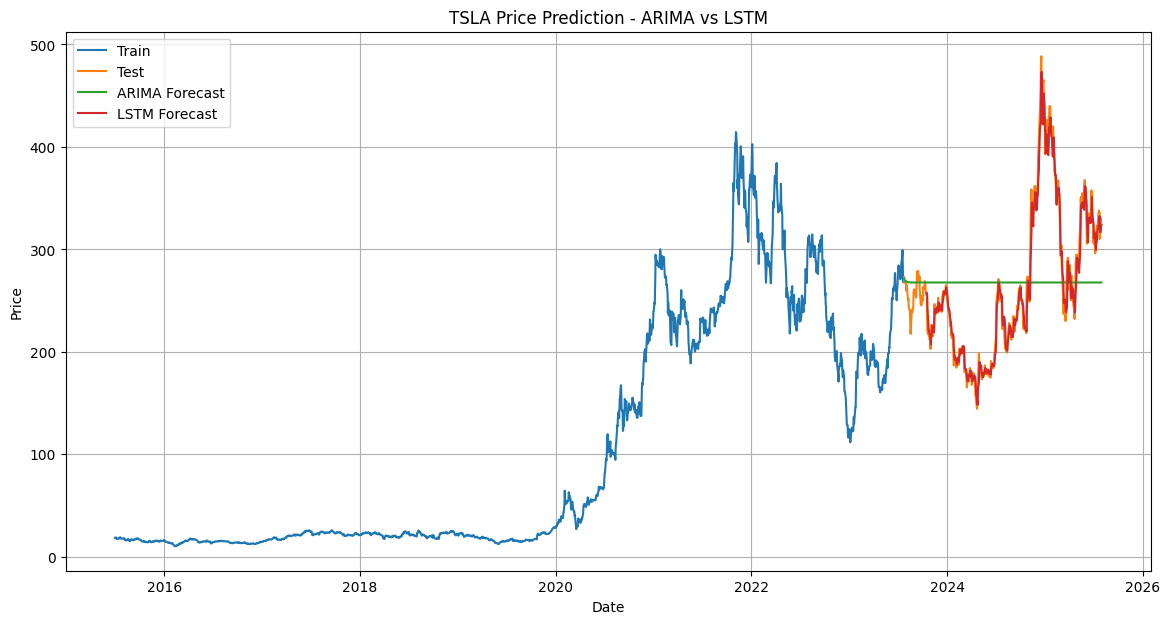

In [ ]:
# Plot results
plt.figure(figsize=(14, 7))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(arima_forecast, label='ARIMA Forecast')
plt.plot(lstm_forecast, label='LSTM Forecast')
plt.title("TSLA Price Prediction - ARIMA vs LSTM")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend()
plt.grid(True)
plt.savefig(r"D:\kaimtenx\project\week11\Time_Series_Portfolio_Management_Optimization\outputs\plots\tsla_forecast_comparison.png")
plt.show()